# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

In [2]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from elements.abstracts import AbstractModulator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
import torch
import numpy
import timm
import pandas
from copy import deepcopy
from cluster import train, confusion, execute, epochs

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8
FigureWidthHeight = (6.69291, 10.1181-1.0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Определение параметров модели

In [5]:
def resnet18(classes:int=10):
    return timm.create_model('resnet18', pretrained=False, in_chans=1, num_classes=classes).to(device)

In [6]:
def combined_loss(cross_entropy_to_mse_proportion:float=1.0):
    def loss_function(outputs, targets):
        CELoss = torch.nn.functional.cross_entropy(outputs, targets)
        MSELoss = torch.nn.functional.mse_loss(torch.nn.functional.softmax(outputs, dim=1), torch.nn.functional.one_hot(targets, num_classes=10).float())
        loss = cross_entropy_to_mse_proportion*CELoss + (1.0-cross_entropy_to_mse_proportion)*MSELoss
        return loss
    return loss_function

In [7]:
# Предпочтительные параметры
size = 7.0E-6
near_N = 800 #2004 #1336
near_length = 5.6E-3
wavelength = 500.0E-9
detectors_amount = 24
masks_amount = 10
distance = 0.03

# Параметры обучения
batch_size = 32
learning_rate = 0.009854
loss_function_proportion = 0.609798
optimizer_type_name = 'Adam'
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

# Параметры когерентности
spatial_coherence = 100.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 10

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size
cppp = int(near_N * size / length)
N = upper_integer(length*cppp / size) 
detector_size = length / 60

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(length/pixels, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

print(f"Размер детекторов:                        {engineering(detector_size, 'м')}")
print(f"Количество детекторов:                    {detectors_amount} на {detectors_amount}")

print(f"Пропорция CE к MSE лосс:                  {loss_function_proportion}")
print(f"Размер батча:                             {batch_size}")
print(f"Тип оптимизатора:                         {optimizer_type_name}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       800
Количество пикселей маски:                800
Размер оптических элементов:              5.6 мм
Размер пикселя маски:                     7.0 мкм
Расстояние между слоями:                  30.0 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           100.0 мкм
Количество усреднений:                    10
Размер детекторов:                        93.333 мкм
Количество детекторов:                    24 на 24
Пропорция CE к MSE лосс:                  0.609798
Размер батча:                             32
Тип оптимизатора:                         Adam


# Диапазон расстояний

In [8]:
# Настройка диапазона
distance_left_multiplier = 0.5
distance_right_multiplier = 1.0

slices = 20
distance_samples = 3
distance_array = numpy.linspace(distance*distance_left_multiplier, distance*distance_right_multiplier, distance_samples)

In [9]:
different_distance_propagations = []
# Вычисления
initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
p0 = N//2 - upper_integer(N*size/(length*2))
p1 = p0 + upper_integer(N*size/length)
if p1 <= p0: p1 = p0+1 
initial[0,0,p0:p1,p0:p1] = 1.0

with torch.no_grad():
    incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
    incoherent_encoder, incoherent_decoder = incoherent.pair()
    incoherent_encoder, incoherent_decoder = incoherent_encoder.to(device), incoherent_decoder.to(device)
    for max_distance in tqdm(distance_array):
        result = torch.zeros((slices, N), dtype=torch.float32)
        for i, dist in enumerate(numpy.linspace(0, max_distance, slices)):
            propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, dist).to(device)
            result = incoherent_decoder.forward(propagation.forward(incoherent_encoder.forward(initial))).squeeze().abs().cpu()
        different_distance_propagations.append((max_distance, result))

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.15s/it]


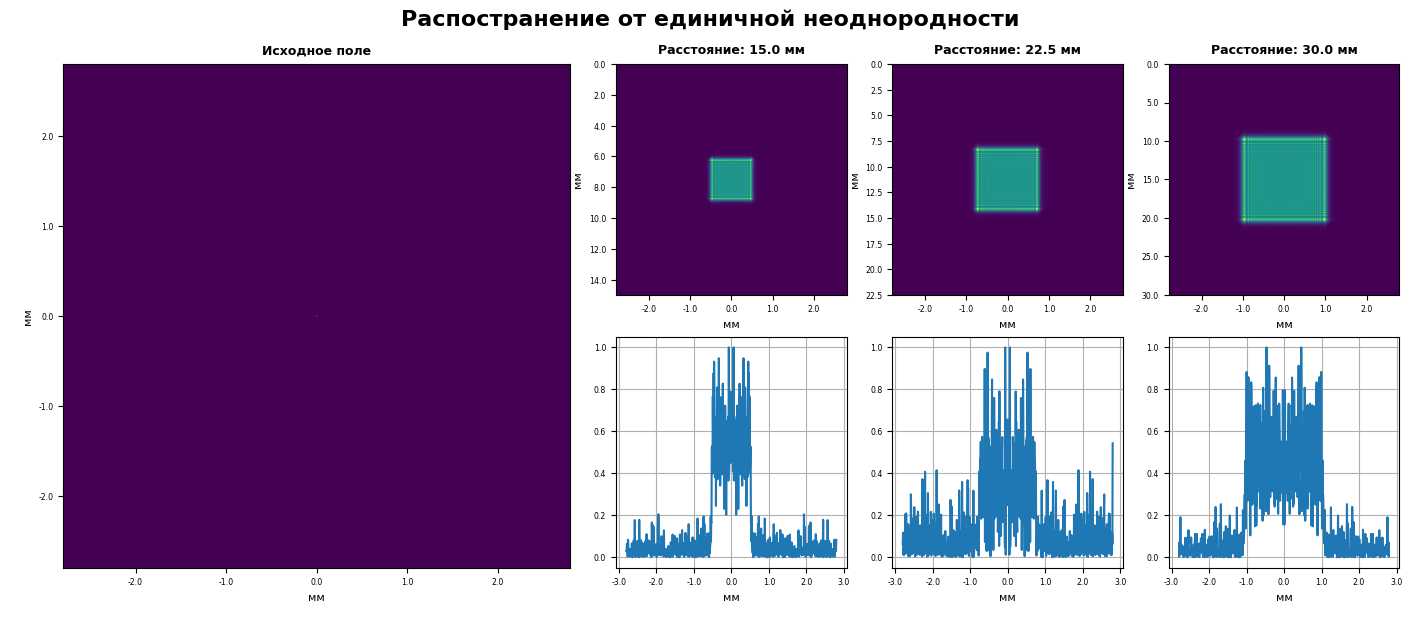

In [10]:
plot = TiledPlot(14, 14)
plot.FontLibrary = FontLibrary
plot.title('Распостранение от единичной неоднородности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')

axes = plot.axes.add((0,0),(1,1))
axes.imshow(initial[0][0].abs().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)

plot.description.column.top('Исходное поле',0,1)

for col, (dist, data) in enumerate(different_distance_propagations, 2):
    formatter_z, unit_z = engineering.separatedformatter(dist, 'м')
    plot.description.column.top(f"Расстояние: {engineering(dist,'м', 2)}", col)
    
    axes = plot.axes.add(col, 0)
    axes.imshow(torch.log10(data+0.001), aspect='auto', extent=[-length/2,+length/2,dist,0])
    axes.xaxis.set_major_formatter(formatter_xy)
    axes.yaxis.set_major_formatter(formatter_z)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_z)

    axes = plot.axes.add(col,1)
    axes.grid(True)
    axes.plot(numpy.linspace(-length/2,+length/2,N), data[-1]/data[-1].max())
    axes.xaxis.set_major_formatter(formatter_xy)
    plot.graph.label.x(unit_xy)

plot.show()

# Инициализация моделей

In [11]:
# Модуль некогерентности
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
incoherent_encoder, incoherent_decoder = incoherent.pair()
incoherent_encoder, incoherent_decoder = incoherent_encoder.to(device), incoherent_decoder.to(device)

# Модули детекторов
spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((detector_size, detector_size), (0,0))
detectors_incoherent = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter).to(device)
detectors_coherent = deepcopy(detectors_incoherent)

# Электронные модели
electronic_incoherent = resnet18()
electronic_coherent = deepcopy(electronic_incoherent)

# Оптические модели
adjuster = AdjustSize(N, N)
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
elements = [phase_modulators[0], amplitude_modulators[0]]
for phase_modulator, amplitude_modulator in zip(phase_modulators[1:], amplitude_modulators[1:]):
    elements.append(propagation)
    elements.append(phase_modulator)
    elements.append(amplitude_modulator)
elements.append(propagation)
optical_incoherent = CompositeModel(adjuster, incoherent_encoder, *deepcopy(elements), incoherent_decoder).to(device)
optical_coherent = CompositeModel(adjuster, *deepcopy(elements)).to(device)

# Гибридные модели
hybrid_model_incoherent = HybridModel(optical_incoherent, detectors_incoherent, electronic_incoherent).to(device)
hybrid_model_coherent = HybridModel(optical_coherent, detectors_coherent, electronic_coherent).to(device)

# Распределённые модели
model_incoherent = hybrid_model_incoherent
model_coherent = hybrid_model_coherent

# Набор данных
dataset = Dataset('CIFAR10', batch_size, None, None, torch.complex64, threads=1, preload=10)
dataset.load.train()
dataset.load.test()

# Тип оптимизатора и лосс-функция
loss_function = combined_loss(loss_function_proportion)
optimizer_type = optimizer_types_list[optimizer_type_name]

In [12]:
model_incoherent._optical_model._elements

(AdjustSize(),
 IncoherentEncoder(
   (_generator): GaussianNormalizer(
     (_generator): FourierMask()
   )
 ),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 IncoherentDecoder())

In [13]:
image, _ = next(iter(dataset.train))
image = image[0:2]
image = image.to(device)
print(image.shape)
image = model_incoherent._optical_model.forward(image)
print(image.shape)
image = model_incoherent._detectors.forward(image)
print(image.shape)
image = model_incoherent._electronic_model.forward(image)
print(image.shape)
torch.cuda.empty_cache()

torch.Size([2, 1, 32, 32])
torch.Size([2, 1, 800, 800])
torch.Size([2, 1, 24, 24])
torch.Size([2, 10])


# Обучение модели

In [ ]:
models_history, loss_histories, confusion_matrices_history = [], [], []
for i in range(10):
    mh, lh, cmh = epochs(20, 10, model_incoherent, dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.000003)
    models_history += mh
    loss_histories += lh
    confusion_matrices_history += cmh

^C
Traceback (most recent call last):
  File "/home/encoder/OpticalEncoder/cluster/functions.py", line 5, in <module>
    import torch
  File "/home/encoder/.local/lib/python3.10/site-packages/torch/__init__.py", line 1695, in <module>
    from torch import quantization as quantization
  File "/home/encoder/.local/lib/python3.10/site-packages/torch/quantization/__init__.py", line 1, in <module>
    from .quantize import *  # noqa: F403
  File "/home/encoder/.local/lib/python3.10/site-packages/torch/quantization/quantize.py", line 10, in <module>
    from torch.ao.quantization.quantize import (
  File "/home/encoder/.local/lib/python3.10/site-packages/torch/ao/quantization/__init__.py", line 3, in <module>
    from .fake_quantize import *  # noqa: F403
  File "/home/encoder/.local/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py", line 5, in <module>
    from torch.ao.quantization.observer import (
  File "/home/encoder/.local/lib/python3.10/site-packages/torch/ao/qua

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f3f940444c0>>
Traceback (most recent call last):
  File "/home/encoder/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Training main thread PID is: 1397364
Training thread#0 PID is: 1397566
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 1397636
Training thread#2 PID is: 1397839
Training thread#3 PID is: 1398044
Training thread#4 PID is: 1398249
Training thread#5 PID is: 1398450
Training thread#6 PID is: 1398651
Training thread#7 PID is: 1398850
W0612 07:16:22.591000 140074139254784 torch/multiprocessing/spawn.py:145] Terminating proce

# Записки:

- Длинна волны:                             500.0 нм
- Количество вычислительных пикселей:       800
- Количество пикселей маски:                800
- Размер оптических элементов:              5.6 мм
- Размер пикселя маски:                     7.0 мкм
- Расстояние между слоями:                  25.0 мм
- Временная когерентность:                  10.0 нс
- Время релаксации:                         1.0 мкc
- Пространственная когерентность:           100.0 мкм
- Количество усреднений:                    20
- Размер детекторов:                        93.333 мкм
- Количество детекторов:                    24 на 24
- Размер батча:                             20
- Тип оптимизатора:                         Adam

*Резуьтат:* 60.48%